In [20]:
import os
import sys 
import glob
import dask
import pyproj
import pickle
import copy
import dask
import xsar
import xrft
import random
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
import types

import cmcrameri.cm as cmc
import drama.utils as drtls
from scipy.signal import fftconvolve
from drama.performance.sar.antenna_patterns import sinc_bp, phased_array

from dataclasses import dataclass
from leakage.velocity_leakage import * #S1DopplerLeakage, add_dca_to_leakage_class, slant2ground, low_pass_filter_2D_dataset, low_pass_filter_2D
from leakage.misc import round_to_hour, angular_difference, calculate_distance, power_spectrum_custom

func_rmse = lambda x, rounding=3:  np.round(np.sqrt(np.mean(x**2)).values*1, rounding)
rmse = lambda x, rounding=3:  np.round(np.sqrt(np.nanmean(x**2)), rounding)
dB = lambda x: 10*np.log10(x)

In [36]:
wavenumber = 112
T_pp = 1.15E-4
np.std(phase_error_gen(0.4, n_samples = 10000, random_state=42) / 2 / wavenumber / T_pp)

55.71303978458197

In [2]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios = [ scenario for scenario in scenarios if "_" != scenario[0] ] 
scenarios.sort()
scenarios

['Aghulas_20190515',
 'Aghulas_20191110',
 'Aghulas_20200121',
 'Aghulas_20200203',
 'Aghulas_20200215',
 'Aghulas_20200227',
 'Aghulas_20200309',
 'Aghulas_20200310',
 'Aghulas_20200321',
 'Aghulas_20200322',
 'Aghulas_20200402',
 'Aghulas_20200403',
 'Aghulas_20200414',
 'Aghulas_20200415',
 'Aghulas_20200426',
 'Aghulas_20200427',
 'Azores_20201127',
 'Barbedos_20201110',
 'Brasilia_20200321',
 'Carrib_20231104',
 'Hawaii_20201106',
 'Iceland_20231107',
 'Morroco_20201103',
 'Scotland_20231109']

In [3]:
scenario = 'Azores_20201127' # 'Aghulas_20200427'# 'Azores_20201127'
files = glob.glob(f"{data_dir+scenario}/*.SAFE")

test = S1DopplerLeakage(
    filename=files,
    # f0=26.5e9,
    z0 = 823_000,
    era5_directory='../../data/leakage/era5_winds/',
    resolution_product=50_000,
    az_footprint_cutoff=80_000,
    vx_sat=6800,
    PRF=4,
    grid_spacing=75,
    antenna_length=2.87,
    antenna_height=0.32,
    beam_pattern= 'phased_array', #'phased_array', sinc
    antenna_elements=4,
    antenna_weighting=0.75,
    swath_start_incidence_angle_scat=35,
    boresight_elevation_angle_scat=40,
    random_state = 42,
    fill_nan_limit = 1,
    product_averaging_window='hann',
    # _interpolator = 'linear',

    # era5_smoothing_window=30,
    # _pulsepair_noise = True
    # _speckle_noise= False
    )

/Users/opodriscoll/Documents/Scripts/DopSCA/src/leakage/velocity_leakage.py:596: UserWarning: Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0
  warnings.warn("Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0")


In [4]:
# test.open_data()
# test.querry_era5()
# test.wdir_from_era5()
# test.wdir_wrt_sensor = 0
# test.create_dataset()
# test.create_beam_mask()
# test.compute_scatt_eqv_backscatter()
# test.compute_beam_pattern()
# test.compute_leakage_velocity()
# test.compute_leakage_velocity_estimate()
test.apply()

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Azores_20201127/A07B_B01D_CA05_CE1B_E23C_res75.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_wind_202011.nc


/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site

In [6]:
# Store
data_to_return = ['az', 'doppler_pulse_rg', 'V_leakage_pulse_rg', 'nrcs_scat', 'V_sigma', 'V_sigma_subscene',
                            'doppler_pulse_rg_subscene', 'doppler_pulse_rg_subscene_inverted',
                            'V_leakage_pulse_rg_subscene', 'V_leakage_pulse_rg_subscene_inverted',
                            'nrcs_scat_subscene', 'doppler_pulse_rg_inverted',
                            'V_leakage_pulse_rg_inverted', 'nrcs_scat_w_noise',
                            'nrcs_scat_subscene_w_noise']

storage_dir = "/Users/opodriscoll/Documents/Scripts/DopSCA/data/leakage/temp"
storage_file = f"{storage_dir}/test_{scenario}_v5.nc"

In [ ]:
# # Store
# # data[data_to_return] = data[data_to_return].chunk('auto').persist()
# test.data[data_to_return].chunk('auto').compute().to_netcdf(storage_file)

In [7]:
# Reload
test.data =  xr.open_dataset(storage_file)

## Misc

In [8]:
nrcs_original.

<xarray.DataArray 'sigma0' (line: 11499, sample: 3404)> Size: 313MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * line     (line) float64 92kB 0.0 74.82 149.6 ... 8.602e+05 8.602e+05
  * sample   (sample) float64 27kB 3.68e+05 3.681e+05 ... 6.222e+05 6.222e+05

In [12]:
data_plot

<xarray.Dataset> Size: 60GB
Dimensions:                               (az_idx: 1067, slow_time: 460,
                                           grg: 3404)
Coordinates:
  * az_idx                                (az_idx) int64 9kB 0 75 ... 79950
  * slow_time                             (slow_time) float64 4kB 40.8 ... 821.1
    grg                                   (slow_time) float64 4kB 40.8 ... 821.1
Data variables: (12/37)
    distance_az                           (az_idx) float32 4kB dask.array<chunksize=(9,), meta=np.ndarray>
    x_sat                                 (slow_time) float32 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    windfield                             (az_idx, grg, slow_time) float32 7GB dask.array<chunksize=(9, 3404, 1), meta=np.ndarray>
    inc_scatt_eqv                         (az_idx, grg) float32 15MB dask.array<chunksize=(9, 3404), meta=np.ndarray>
    nrcs_scat_eqv                         (az_idx, grg, slow_time) float32 7GB dask.array<chunksize=(9, 3404, 1), meta=np.ndarray>
    nrcs                                  (az_idx, grg, slow_time) float32 7GB dask.array<chunksize=(9, 3404, 1), meta=np.ndarray>
    ...                                    ...
    doppler_pulse_rg_inverted             (grg, slow_time) float32 6MB dask.array<chunksize=(3404, 460), meta=np.ndarray>
    doppler_pulse_rg_subscene_inverted    (grg, slow_time) float64 13MB dask.array<chunksize=(3404, 460), meta=np.ndarray>
    V_leakage_pulse_rg_inverted           (grg, slow_time) float32 6MB dask.array<chunksize=(3404, 460), meta=np.ndarray>
    V_leakage_pulse_rg_subscene_inverted  (grg, slow_time) float64 13MB dask.array<chunksize=(3404, 460), meta=np.ndarray>
    nrcs_scat_w_noise                     (grg, slow_time) float32 6MB dask.array<chunksize=(3404, 460), meta=np.ndarray>
    nrcs_scat_subscene_w_noise            (grg, slow_time) float64 13MB dask.array<chunksize=(3404, 460), meta=np.ndarray>
Attributes: (12/31)
    grid_spacing:                      75
    filename:                          ['/Users/opodriscoll/Documents/Data/Se...
    f0:                                5400000000.0
    z0:                                823000
    antenna_length:                    2.87
    antenna_height:                    0.32
    ...                                ...
    _speckle_noise:                    True
    _interpolator:                     linear
    _gamma_hardcode:                   None
    Lambda:                            0.05555555555555555
    stride:                            1700.0
    az_mask_pixels_cutoff:             533

In [17]:
ver_max

860250.0

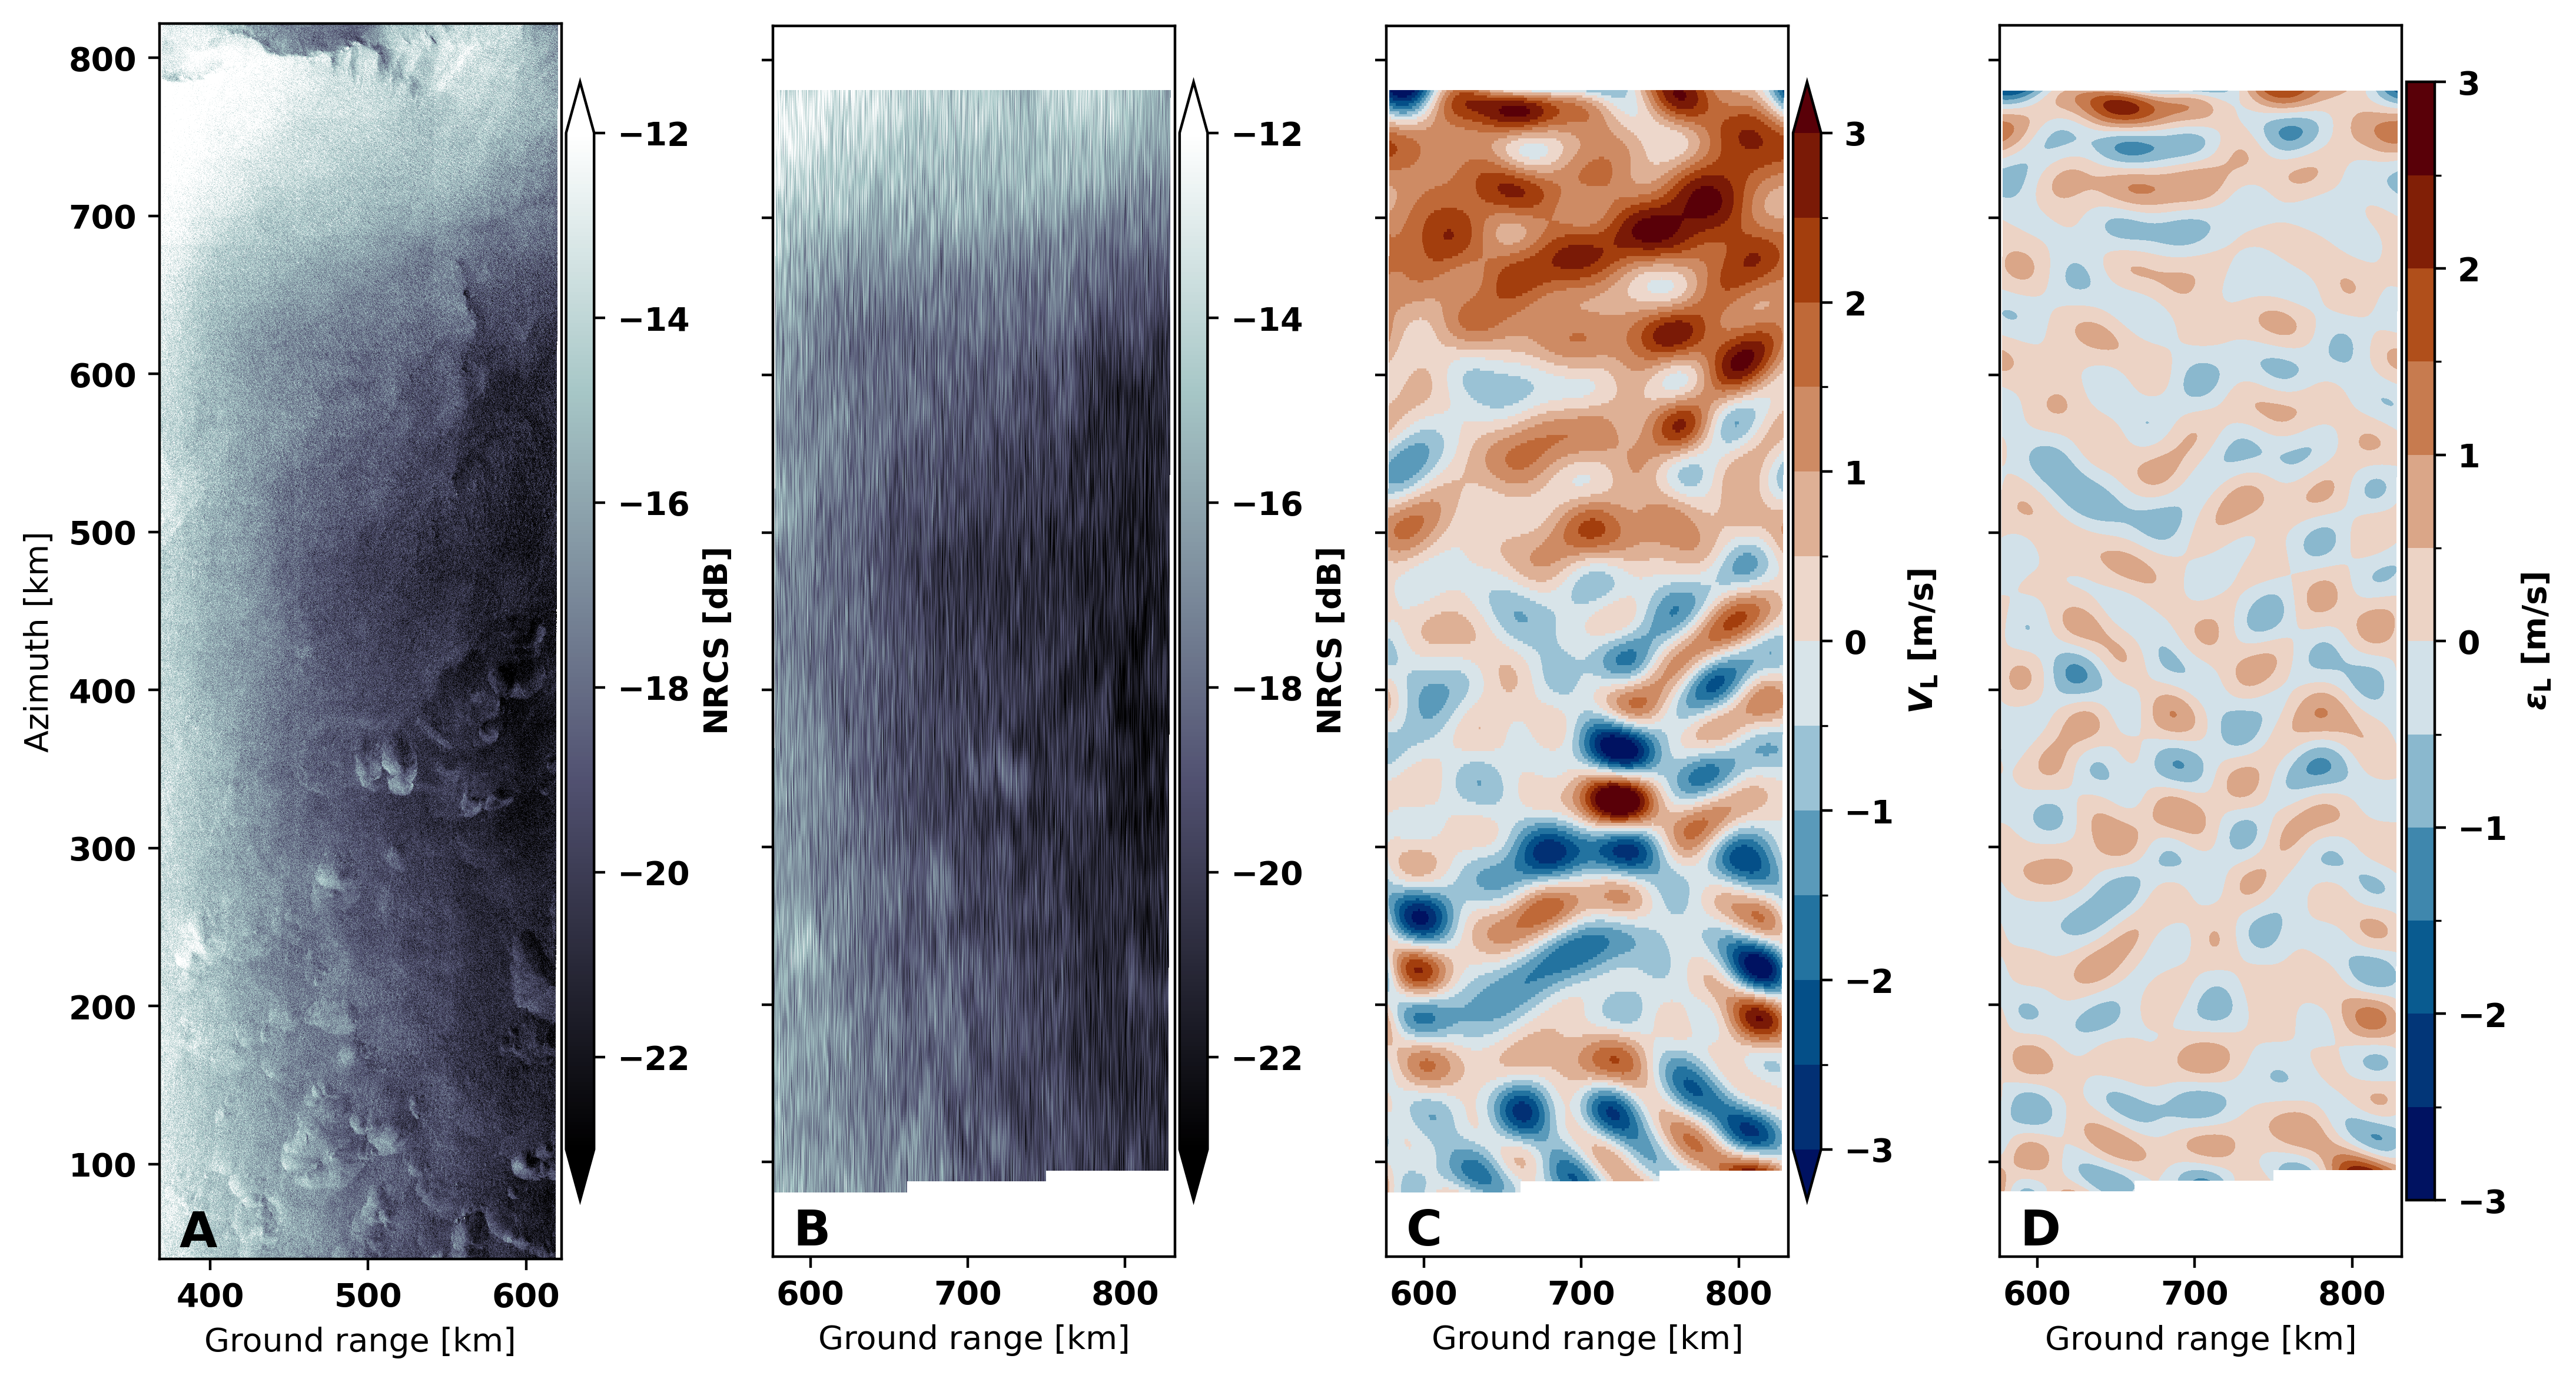

In [19]:
plt.rcParams.update({'font.size': 10, 'font.weight' : 'bold'})
cbar_kwargs = {'shrink':0.9, 'aspect':40, 'pad' : 0.01, 'extend':'both'}
plot_kwargs = {'robust': True}
plot_kwargs_nrcs = {'vmin': -23, 'vmax':-12}
vmin = 3
plot_leakage_kwargs = {'vmin': -vmin, 'vmax': vmin, 'cmap' : cmc.vik, 'levels' : 13}
plot_leakage_net_kwargs = {'vmin': -vmin, 'vmax': vmin, 'cmap' : cmc.vik, 'levels' : 13}# {'vmin': -1, 'vmax': 1, 'cmap' : cmc.bam_r, 'levels' : 9}
label_kwargs = {'xlabel':'Range [m]', 'ylabel':'Azimuth [m]'}

data_plot = test.data
divide_by = 1000
data_plot = data_plot.assign_coords(slow_time=data_plot.slow_time/divide_by, grg = data_plot.grg/divide_by)

net_leakage = data_plot.V_leakage_pulse_rg_subscene - data_plot.V_leakage_pulse_rg_subscene_inverted
net_velocity_error =  data_plot.V_sigma_subscene - data_plot.V_leakage_pulse_rg_subscene_inverted
nx = 4; ny = 1
fig, axes = plt.subplots(ny, nx, figsize = (11, 6), sharex=False, sharey=True)
axes_indexes = np.argwhere(axes)

plot_cut = net_velocity_error / net_velocity_error


ver_max = (data_plot.az.max() + abs(data_plot.az.min())).values*1 / divide_by
ver_min = 0 #/ divide_by
grg_average = test.S1_file.ground_range_approx.mean(dim = 'line') / divide_by
hor_max = grg_average.max().values
hor_min = grg_average.min().values

az_new = np.linspace(ver_min, ver_max, test.S1_file.sigma0.sizes['line'])
grg_new = np.linspace(hor_min, hor_max, test.S1_file.sigma0.sizes['sample'])
nrcs_original = 10*np.log10(test.S1_file.drop_vars('pol').assign_coords(line=('line', az_new), sample = ('sample', grg_new)).sigma0)

nrcs_original.plot(ax= axes[*axes_indexes[0]], 
                   **{'cmap': 'bone', **plot_kwargs_nrcs},
                   cbar_kwargs = {'label':r'$\mathrm{NRCS\ [dB]}$', **cbar_kwargs})

(10*np.log10(data_plot.nrcs_scat_w_noise)).T.plot(ax= axes[*axes_indexes[1]],#[0,0], 
                                          **{'cmap': 'bone', **plot_kwargs_nrcs},
                                          cbar_kwargs = {'label':r'$\mathrm{NRCS\ [dB]}$', **cbar_kwargs})
# (10*np.log10(data_plot.nrcs_scat_w_noise * plot_cut)).T.plot(ax= axes[*axes_indexes[1]],#[0,1], 
#                                                   **{'cmap': 'bone', **plot_kwargs},
#                                                   cbar_kwargs = {'label':'nrcs [dB]', **cbar_kwargs})
# (data_plot.V_sigma_subscene * plot_cut).T.plot(ax= axes[*axes_indexes[1]],#[0,2], 
#                                              **{**plot_leakage_kwargs, **plot_kwargs},
#                                              cbar_kwargs = {'label':r'$\sigma_{\mathrm{pp}} + V_{\mathrm{L}}\ \mathrm{[m/s]}$', **cbar_kwargs})
(data_plot.V_leakage_pulse_rg_subscene * plot_cut).T.plot(ax= axes[*axes_indexes[2]],#[1,0],
                    **{**plot_leakage_kwargs, **plot_kwargs},
                    cbar_kwargs = {'label':r'$V_{\mathrm{L}}\ \mathrm{[m/s]}$', 'extend':'both', **cbar_kwargs})
temp = (net_leakage ).T.plot.contourf(ax= axes[*axes_indexes[3]],#[1,1],
                    **{**plot_leakage_net_kwargs, **plot_kwargs},
                    cbar_kwargs = {'label':r'$\epsilon_{\mathrm{L}}\ \mathrm{[m/s]}$', 'extend':'both', **cbar_kwargs})
# plt.colorbar(temp, extend='neither')
# (net_velocity_error).T.plot.contourf(ax= axes[*axes_indexes[4]],#[1,2],
#                     **{**plot_leakage_net_kwargs, **plot_leakage_kwargs},
#                     cbar_kwargs = {'label':r'$\sigma_{\mathrm{pp}} + \epsilon_{\mathrm{L}}\ \mathrm{[m/s]}$', **cbar_kwargs})

res = test.resolution_product/1000
# titles = ['SCA Backscatter', 'SCA Backscatter + speckle', f'Total velocity error \n@ {res:2} km', 
# titles = ['SCA Backscatter', f'Total velocity error \n@ {res:2} km', 
#           f'Total leakage velocity \n@ {res:2} km', f'Residual leakage velocity \n@ {res:2} km', f'Residual velocity error \n@ {res:2} km']
# titles = ['SCA Backscatter', f'Total velocity error', 
#           f'Total leakage velocity \n@ {res:2} km', f'Residual leakage velocity \n@ {res:2} km', f'Residual velocity error \n@ {res:2} km']
titles = ['S1 Backscatter', 'SCA Backscatter', 
          f'Total leakage velocity \n@ {res:2} km', f'Residual leakage velocity \n@ {res:2} km']
# x_labels = [''] * (nx * np.max([0, ny-1])) + ['Ground range [m]'] * (nx * (ny))
# x_labels = [''] * 2 + ['Ground range [m]'] + [''] * 2
x_labels = ['Ground range [km]'] * 4
y_labels = (['Azimuth [km]'] + [''] * (nx - 1)) * ny
# _ = [ax.axes.set_title(i) for ax, i in zip(axes.ravel(), titles)]
_ = [ax.axes.set_xlabel(i) for ax, i in zip(axes.ravel(), x_labels)]
_ = [ax.axes.set_ylabel(i) for ax, i in zip(axes.ravel(), y_labels)]
_ = [ax.axes.set_aspect('equal') for ax in axes.ravel()]
# _ = [ax.ticklabel_format(useMathText=True, axis = 'both', style='scientific', scilimits=(2,4)) for ax in axes.ravel()]
_ = [ax.axes.get_xaxis().get_offset_text().set_position((1.2,-40)) for ax in axes.ravel()]
# labels = [i.upper() for i in ['a', 'b', 'c', 'd', 'e']]
labels = [i.upper() for i in ['a', 'b', 'c', 'd']]
_ = [ax.text(0.05, 0.04, label, fontsize=15, transform=ax.transAxes, va='top') for ax, label in zip(axes.ravel(), labels)]

fig.set_dpi(400.0) 

plt.tight_layout()

In [ ]:
func_rmse(net_leakage)

0.419

In [ ]:
func_rmse(test.data.V_sigma_subscene * plot_cut), func_rmse(net_velocity_error)

(2.403, 2.106)

In [ ]:
func_rmse(test.data.V_leakage_pulse_rg_subscene * plot_cut)

1.203

In [ ]:
fs_x = 1/test.grid_spacing
fs_y = 1/test.stride
pulse_pair_noise = (test.data.V_sigma - test.data.V_leakage_pulse_rg)* plot_cut
a = low_pass_filter_2D(pulse_pair_noise, 
                       cutoff_frequency= 1/test.resolution_product,
                       fs_x=fs_x,
                       fs_y=fs_y,
                       fill_nans = True)#.plot()

func_rmse(a)

/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


2.044

In [6]:
func_rmse(net_leakage)

0.668

In [7]:
func_rmse(test.data.V_sigma_subscene * plot_cut), func_rmse(net_velocity_error)

(4.304, 4.174)

In [11]:
func_rmse(test.data.V_leakage_pulse_rg_subscene * plot_cut)

1.204

In [12]:
fs_x = 1/test.grid_spacing
fs_y = 1/test.stride
pulse_pair_noise = (test.data.V_sigma - test.data.V_leakage_pulse_rg)* plot_cut
a = low_pass_filter_2D(pulse_pair_noise, 
                       cutoff_frequency= 1/test.resolution_product,
                       fs_x=fs_x,
                       fs_y=fs_y,
                       fill_nans = True)#.plot()

func_rmse(a)

/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


4.132

## Signal to Noise

In [ ]:
data_dir_dca = "/Users/opodriscoll/Documents/Data/Sentinel1/DCA/"
files_dca = glob.glob(f"{data_dir_dca+scenario}/*.nc")
# files_dca = [file for file in files_dca if 'S1A' in file]

# add_dca_to_leakage_class(test, files_dca=files_dca)

In [ ]:
def signal_2_noise_ratio(signal, noise):
    return signal**2 / noise**2

def to_decibel(x):
    return 10*np.log10(x)

def from_decibel(x):
    return 10**(x/10)

In [ ]:
snr = to_decibel(signal_2_noise_ratio(signal=test.data.V_dca_pulse_rg_subscene, noise=net_leakage,))

-0.0816581 13.492082


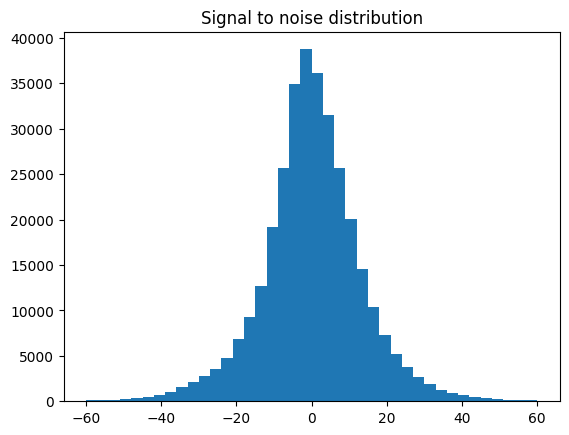

In [ ]:
_ = snr.plot.hist(bins = 40, range = (-60, 60))
plt.title('Signal to noise distribution')
print(np.nanmedian(snr), np.nanstd(snr))

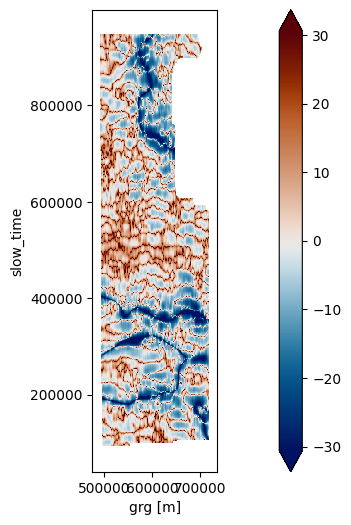

In [ ]:
fig, axes = plt.subplots(1, 1, figsize = (16, 6), sharex=True, sharey=True)
snr.T.plot(robust =True, cmap =cmc.vik, ax=axes)
axes.axes.set_aspect('equal')

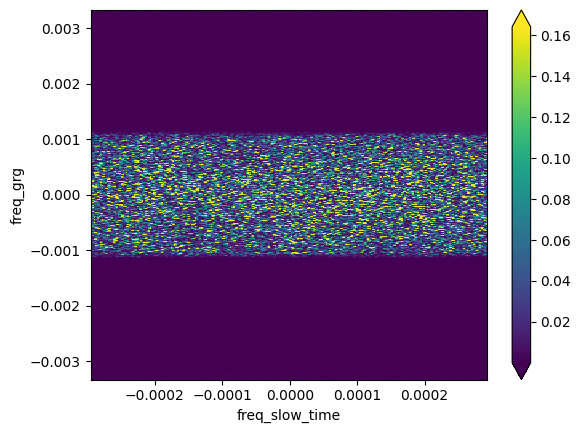

In [ ]:
power_spectrum_custom(test.data.V_pp.chunk({**test.data.V_pp.sizes}),detrend= 'constant', window = 'hann', scaling = 'spectrum').plot(robust = True)

## Moving average vs Fourier filter

/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


(-30.0, 0.0)

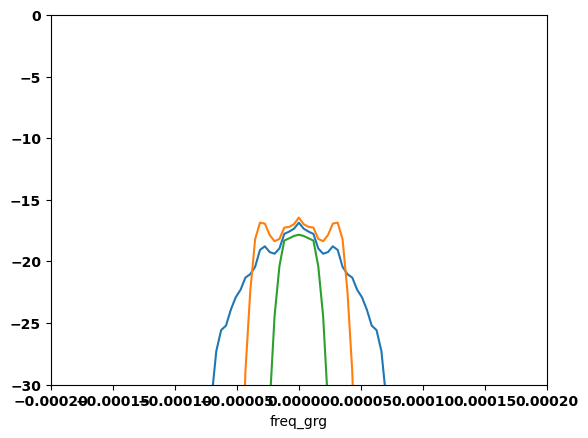

In [ ]:
scaling = 'spectrum'

# t = test.data.V_pp.persist().rolling(grg=test.grg_N//2, slow_time=test.slow_time_N//2, center=True).mean()
t = test.data.V_pp.persist().rolling(grg=147, slow_time=6, center=True).mean()
tt = power_spectrum_custom(t.chunk({**t.sizes}), scaling = scaling)
ttt = 10*np.log10(tt.sel(freq_slow_time = slice(-0.00003, 0.00003)).mean(axis = 1))
tttt = xr.where((ttt - ttt.max()) < -3, 1, np.nan)

fs_x=1/test.grid_spacing
fs_y=1/test.stride
l = low_pass_filter_2D(test.data.V_pp, cutoff_frequency=1/25_000, fs_x=fs_x, fs_y=fs_y, fill_nans=True, window = 'hann')
m = low_pass_filter_2D(test.data.V_pp, cutoff_frequency=1/50_000, fs_x=fs_x, fs_y=fs_y, fill_nans=True, window = 'hann')

dimensions = [*test.data.V_pp.sizes]
for dimension in dimensions:
    l[dimension] = test.data.V_pp[dimension]
    m[dimension] = test.data.V_pp[dimension]

ll = power_spectrum_custom(l.chunk({**l.sizes}), scaling = scaling)
mm = power_spectrum_custom(m.chunk({**m.sizes}), scaling = scaling)
lll = 10*np.log10(ll.sel(freq_slow_time = slice(-0.00003, 0.00003)).mean(axis = 1))
mmm = 10*np.log10(mm.sel(freq_slow_time = slice(-0.00003, 0.00003)).mean(axis = 1))

ttt.plot(), lll.plot(), mmm.plot()
plt.xlim([-0.0002, 0.0002])
plt.ylim([-30, 0])


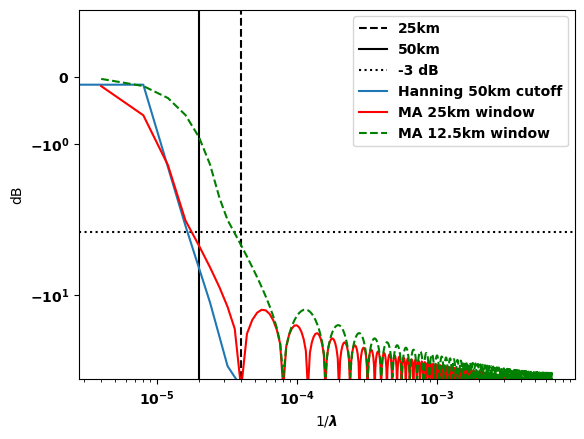

In [ ]:
from scipy.signal import firwin

def intensity(magnitude):
    N = len(magnitude)
    I = (abs(magnitude) / N)**2
    return I

start = 0
stop = 250000
fs = 1/75
dx = 1/fs
N1 = (12500 * fs) // 1
N2 = (25000 * fs) // 1
f_delta = 1 / (stop-start)
f_max = 1/(dx*2)
f_min = 0

f = np.arange(f_min, f_max, f_delta)
omega = 2 * np.pi * f / fs
N = int(len(f))

H1 = 10*np.log10((1/ N1 * abs(np.sin(omega*N1 / 2) / np.sin(omega/2)))**2)
H2 = 10*np.log10((1/ N2 * abs(np.sin(omega*N2 / 2) / np.sin(omega/2)))**2)

w = N*firwin(numtaps = N, cutoff=1/50000, fs=fs, pass_zero=True, window='hann') 

W = np.fft.fftshift(intensity(np.fft.fft(w)))
f_w = np.fft.fftshift(np.fft.fftfreq(n = int(N), d = dx))

plt.axvline(1/25000, c = 'k', ls = '--', label = '25km')
plt.axvline(1/50000, c = 'k', ls = '-',label = '50km')
plt.axhline(-3, c = 'k', ls = ':',label = '-3 dB')

plt.plot(f_w, 10*np.log10(W), label = 'Hanning 50km cutoff')
plt.plot(f, H2, c = 'r', ls = '-', label = 'MA 25km window')
plt.plot(f, H1, c = 'g', ls = '--', label = 'MA 12.5km window')
plt.legend()
plt.xscale('log')
plt.ylim([-50, 1])
plt.ylabel('dB')
plt.xlabel(r'1/$\lambda$')
plt.yscale('symlog')

## Coherence check

In [ ]:
wavenumber = 2 * np.pi / test.Lambda

# -- calculates average azimuthal beam standard deviation within -3 dB 
beam_db = 10 * np.log10(test.data.beam)
beam_3dB = xr.where((beam_db- beam_db.max(dim = 'az_idx'))< -3, np.nan, 1)*test.data.az_angle_wrt_boresight
sigma_az_angle = beam_3dB.std(dim = 'az_idx').mean().values*1

T_corr_Doppler = 1 / (np.sqrt(2) * wavenumber * test.vx_sat * sigma_az_angle) # equation 7 from Rodriguez et al., (2018)
T_pp = test.T_pp # intra pulse-pair pulse separation time, Hoogeboom et al., (2018)
U = 6 # Average wind speed assumed of 6 m/s
T_corr_surface = 3.29 * test.Lambda / U

In [ ]:
N_T_pp = 7  #-5
T_pps = np.logspace(-6, -3, N_T_pp)
SNRs = 2**np.arange(0, 14, 2)
N_SNR = len(SNRs)

input_T_pp = np.broadcast_to(T_pps, (N_SNR, N_T_pp)).T.ravel()
input_SNR = np.broadcast_to(SNRs, (N_T_pp, N_SNR)).ravel()
_ , gammas = pulse_pair_sigma_v_rodriguez2018(
    T_pp = input_T_pp,
    T_corr_surface =  T_corr_surface,
    T_corr_Doppler =  T_corr_Doppler,
    SNR =  input_SNR,
    Lambda =  test.Lambda,
    N_L = 1)


phase_errors = np.array([phase_error_gen(gamma, n_samples = 10000, random_state=test.random_state) for gamma in gammas])
velocity_errors = np.std(phase_errors / 2 / wavenumber / test.T_pp, axis=1)

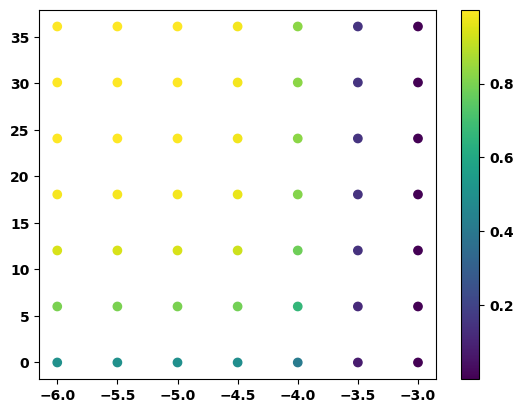

In [ ]:
plt.scatter(np.log10(input_T_pp), dB(input_SNR), c = gammas); plt.colorbar()

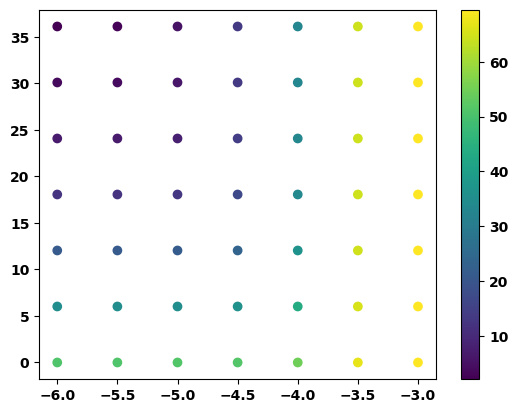

In [ ]:
plt.scatter(np.log10(input_T_pp), dB(input_SNR), c = velocity_errors); plt.colorbar()